# 위도 경도 좌표정보를 이용해서 사고다발지별로 군집화, 새로운 변수 생성해보기

In [15]:
#-*- coding: euc-kr -*-

import plotly.plotly as py
import plotly.graph_objs as go

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import mixture

from sklearn.cluster import DBSCAN
from sklearn import metrics

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100


# 데이터셋 저장 경로
ACCIDENT_PATH = "../9th_week/교통사망사고정보"
SUPPLEMENT_PATH1 = "../9th_week/보조데이터/04.무단횡단사고다발지"
SUPPLEMENT_PATH2 = "../9th_week/보조데이터/05.보행노인사고다발지"
SUPPLEMENT_PATH3 = "../9th_week/보조데이터/06.보행어린이사고다발지"
SUPPLEMENT_PATH4 = "../9th_week/보조데이터/07.스쿨존내사고다발지"
SUPPLEMENT_PATH5 = "../9th_week/보조데이터/08.자전거사고다발지"
SUPPLEMENT_PATH6 = "../9th_week/보조데이터"


def load_accident_data(accident_path=ACCIDENT_PATH):
    csv_path = os.path.join(accident_path, "Kor_Train_교통사망사고정보(12.1~17.6).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train = load_accident_data()

In [16]:
train.head(5)

,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,사고유형,법규위반_대분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도
0,2017,2017063023,14,야간,금,1,1,0,0,0,경기,성남시,차대사람,횡단중,횡단중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,보행자,보행자,967633,1937456,127.134130,37.435704
1,2017,2017063021,45,야간,금,1,4,2,1,0,전남,곡성군,차대차,추돌,추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,승용차,승용차,966456,1696405,127.131220,35.262534
2,2017,2017063021,50,야간,금,1,1,0,0,0,충남,서산시,차대사람,차도통행중,차도통행중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,보행자,보행자,900057,1865697,126.379922,36.784142
3,2017,2017063019,10,야간,금,1,1,0,0,0,대구,서구,차대차,측면충돌,측면충돌,운전자법규위반,안전운전 의무 불이행,교차로,교차로부근,승용차,승용차,이륜차,이륜차,1095230,1764891,128.554945,35.875973
4,2017,2017063017,2,주간,금,1,2,1,0,0,서울,영등포구,차대차,측면충돌,측면충돌,운전자법규위반,중앙선 침범,단일로,교량위,이륜차,이륜차,화물차,화물차,947576,1946355,126.906786,37.514993


###  발생지 변수생성
발생지시도와 발생지시군구를 합쳐서 발생지 변수를 생성 총 231개 발생지가 나온다

In [138]:
train['발생지'] = train['발생지시도'] + train['발생지시군구']
len(np.unique(train['발생지']))
train['발생지']

0         경기성남시
1         전남곡성군
2         충남서산시
3          대구서구
4        서울영등포구
5          광주서구
6         대구달성군
7         경기용인시
8         충남서산시
9         전남광양시
10        광주광산구
11         부산중구
12        충북음성군
13        경기화성시
14        강원원주시
15        경기고양시
16        충남논산시
17         광주동구
18        경남고성군
19        경기안산시
20        전남목포시
21        서울강서구
22        경기시흥시
23        경기이천시
24        부산사상구
25        경기고양시
26        서울광진구
27       서울서대문구
28        경기양평군
29       경기남양주시
30        서울동작구
31        부산기장군
32        충남예산군
33         인천남구
34        전남여수시
35        충북제천시
36         세종세종
37        강원춘천시
38        경기화성시
39        경북의성군
40        충북충주시
41        서울서초구
42        충남금산군
43        경남밀양시
44        경북김천시
45        경기고양시
46        경남고성군
47        충남아산시
48         인천서구
49        전북군산시
          ...  
24987     경기안성시
24988     경기성남시
24989    경기남양주시
24990     경남김해시
24991     경기수원시
24992     전남장성군
24993     전북군산시
24994     서울강남구
24995     전북전주시
24996     전남여수시
24997     서울도봉구
24998   

In [18]:
train = train[(train.경도 > 125) & (train.경도 < 130) & (train.위도 > 34) & (train.위도 < 38.5)]

In [19]:
train['발생지'] = train['발생지시도'] + train['발생지시군구']
len(np.unique(train['발생지']))

228

In [20]:
X = train[["경도", "위도"]].values

In [21]:
db = DBSCAN(eps=0.01, min_samples=9).fit(X)     ## 221 
#db = DBSCAN(eps=0.02, min_samples=13).fit(X)   ## 154
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 221


In [22]:
unique_labels = set(labels)
len(labels[labels == 1])

648

### DBSCAN을 사용해서 군집화를 해보면
색깔이 있는 원은 각 군집의 중심을 나타내고 상대적으로 작고 검은색 점은 군집에 포함되지 않는 노이즈를 나타낸다<br>
그럼 여기서 내가 해야할 작업은 각 군집의 중심을 기준으로 발생지 231개가 어떤 군집에 포함이 되고, 포함이 된다면 확률은 얼마인지 나타내야 하는것

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



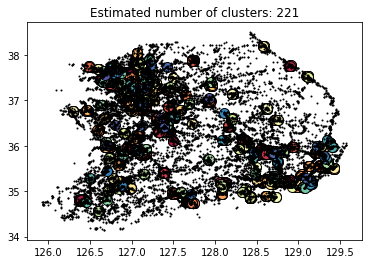

In [23]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### components의 수를 몇개로 할것인가?
발생지시도와 발생지시군구를 합쳐서 만든 변수인 발생지 변수에선 231 개의 구역이 나왔다<br>
행정구역상 기준으로한다면 위 기준으로 하는 것이 맞으나<br>
사고다발지를 계산해서 데이터 자체에 의미있는 새로운 변수를 생성하는데는 적합하지 않을수있다<br>
아래 그래프는 gmm과 같은 generative 모델의 경우 데이터에 주어지는 고유의 확률분포에 따라<br>
정보량을 측정할수있는 측정기준을 제공한다, AIC와 BIC는 각각 다음과 같다 <br>
Akaike information criterion<br>
Bayesian information criterion<br><br>

교통사망사고 데이터에 AIC, BIC 함수를 이용해서 components의 수를 찾아보면<br>
BIC는 우리가 160개 정도를 선택하는게 적절한 것을 알려준다<br>

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



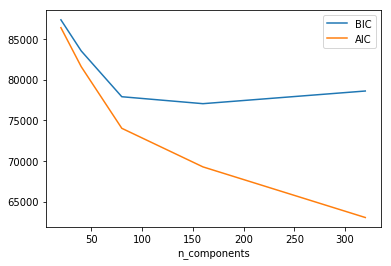

In [24]:
n_components = [20, 40, 80, 160, 320]
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

###  GaussianMixture 모델을 사용해서 군집화를 해보면
이전 모델과는 달리 components의 갯수를 직접 설정해주어야 한다
(160개로 설정한 이유는 아래 부분 참고)<br>
가우시안 모델이다보니 따로 노이즈로 표시되지 않고 같은 클러스터라면 우선 동일한 색으로 표시가된다<br>

In [25]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=160, covariance_type='full', random_state=42).fit(X)
labels = gmm.predict(X)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



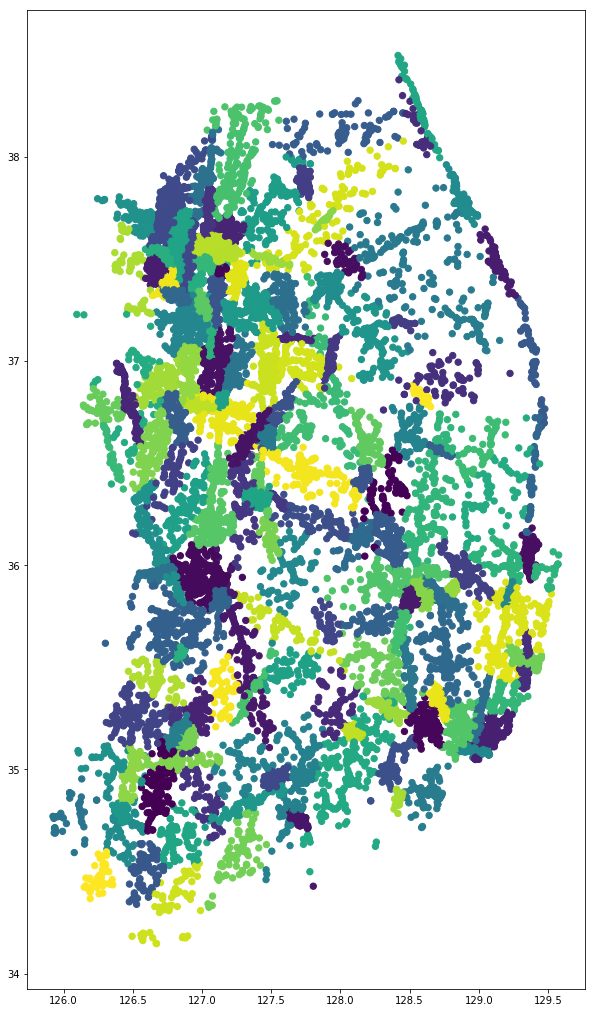

In [26]:
plt.figure(figsize=(10,18))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [27]:
probas = gmm.predict_proba(X)
probas.shape

np.amax(probas, axis=1)

array([0.87533603, 0.9890083 , 0.80929418, ..., 0.80838855, 0.99832886,
       0.78569689])

In [28]:
labels.shape

(24538,)

In [29]:
dpgmm = mixture.BayesianGaussianMixture(n_components=160, covariance_type='full').fit(X)
labels = dpgmm.predict(X)

/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:264: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.



/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



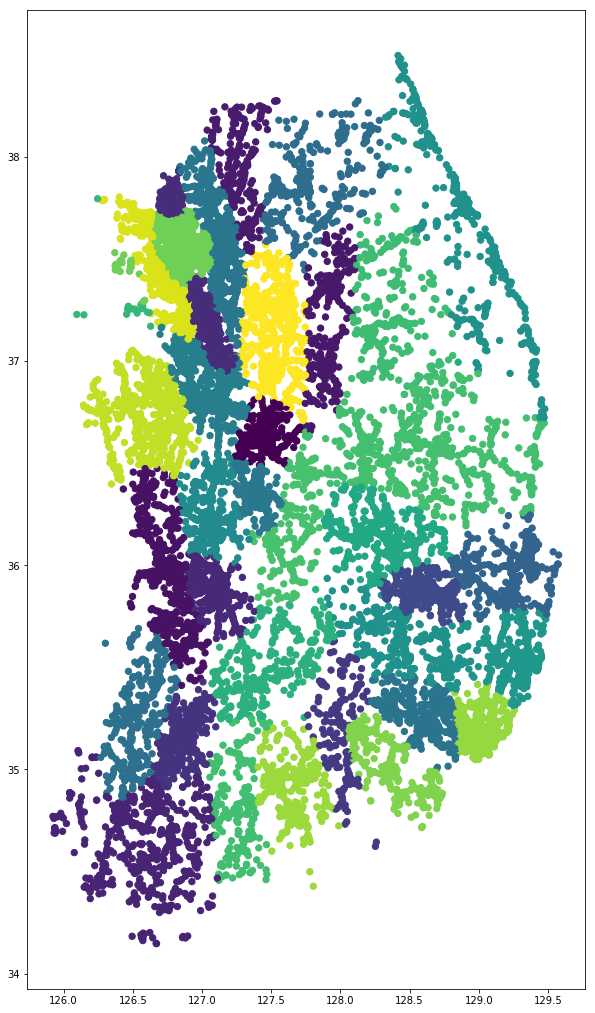

In [30]:
plt.figure(figsize=(10,18))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [31]:
dpprobas = dpgmm.predict_proba(X)
dpprobas.shape

dp_probas = np.amax(dpprobas, axis=1)

In [32]:
dp_probas.shape

(24538,)

In [33]:
labels.shape

(24538,)

In [34]:
train["클러스터번호"] = labels

train["클러스터속할확률"] = dp_probas

In [35]:
train.head(5)

,발생년,발생년월일시,발생분,주야,요일,사망자수,사상자수,중상자수,경상자수,부상신고자수,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,사고유형,법규위반_대분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_1당,당사자종별_2당_대분류,당사자종별_2당,발생위치X_UTMK,발생위치Y_UTMK,경도,위도,발생지,클러스터번호,클러스터속할확률
0,2017,2017063023,14,야간,금,1,1,0,0,0,경기,성남시,차대사람,횡단중,횡단중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,보행자,보행자,967633,1937456,127.134130,37.435704,경기성남시,57,0.671387
1,2017,2017063021,45,야간,금,1,4,2,1,0,전남,곡성군,차대차,추돌,추돌,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,승용차,승용차,966456,1696405,127.131220,35.262534,전남곡성군,91,0.464485
2,2017,2017063021,50,야간,금,1,1,0,0,0,충남,서산시,차대사람,차도통행중,차도통행중,운전자법규위반,안전운전 의무 불이행,단일로,기타단일로,승용차,승용차,보행자,보행자,900057,1865697,126.379922,36.784142,충남서산시,128,0.969093
3,2017,2017063019,10,야간,금,1,1,0,0,0,대구,서구,차대차,측면충돌,측면충돌,운전자법규위반,안전운전 의무 불이행,교차로,교차로부근,승용차,승용차,이륜차,이륜차,1095230,1764891,128.554945,35.875973,대구서구,34,0.955768
4,2017,2017063017,2,주간,금,1,2,1,0,0,서울,영등포구,차대차,측면충돌,측면충돌,운전자법규위반,중앙선 침범,단일로,교량위,이륜차,이륜차,화물차,화물차,947576,1946355,126.906786,37.514993,서울영등포구,111,0.675877


### 현재 테스트 데이터에는 위도,경도 좌표가 없고 발생지 정보만 있다
train 데이터셋에선 동일한 발생지이더라도(발생지시도+발생지시군구) 다른 군집에 속할수도 있다<br>
대표적인 군집과 각각의 확률을 어떻게 구할것인가?<br><br>

단순 평균으로 군집과 확률을 계산해도 결과에 영향을 미치지 않을까?


In [36]:
#train_cluster_mean = train.groupby(['발생지', '클러스터번호'])['클러스터속할확률'].mean()
#train_cluster_mean

train_cluster_mean = train.groupby(['발생지','클러스터번호']).mean()['클러스터속할확률'].reset_index()
train_cluster_mean

,발생지,클러스터번호,클러스터속할확률
0,강원강릉시,72,0.989100
1,강원고성군,72,0.962456
2,강원동해시,72,0.988152
3,강원삼척시,72,0.970768
4,강원속초시,72,0.981380
5,강원양구군,52,0.971644
6,강원양양군,72,0.981549
7,강원영월군,98,0.893440
8,강원원주시,12,0.825164
9,강원원주시,98,0.649844


In [37]:
train_cluster_mean[train_cluster_mean['클러스터속할확률'] == train_cluster_mean.groupby(['발생지'])['클러스터속할확률'].transform(max)]

,발생지,클러스터번호,클러스터속할확률
0,강원강릉시,72,0.989100
1,강원고성군,72,0.962456
2,강원동해시,72,0.988152
3,강원삼척시,72,0.970768
4,강원속초시,72,0.981380
5,강원양구군,52,0.971644
6,강원양양군,72,0.981549
7,강원영월군,98,0.893440
8,강원원주시,12,0.825164
11,강원인제군,52,0.804232


In [38]:
def load_supplement_jaywalk(accident_path=SUPPLEMENT_PATH1):
    csv_path = os.path.join(accident_path, "무단횡단사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')
train_jaywalk = load_supplement_jaywalk()

In [39]:
def load_supplement_oldwalk(accident_path=SUPPLEMENT_PATH2):
    csv_path = os.path.join(accident_path, "보행노인사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train_oldwalk = load_supplement_oldwalk()

In [40]:
def load_supplement_childwalk(accident_path=SUPPLEMENT_PATH3):
    csv_path = os.path.join(accident_path, "보행어린이사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train_childwalk = load_supplement_childwalk()

In [41]:
def load_supplement_schoolzone(accident_path=SUPPLEMENT_PATH4):
    csv_path = os.path.join(accident_path, "스쿨존내어린이사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train_schoolzone = load_supplement_schoolzone()

In [42]:
def load_supplement_bikezone(accident_path=SUPPLEMENT_PATH5):
    csv_path = os.path.join(accident_path, "자전거사고다발지(2012~2016).csv")
    return pd.read_csv(csv_path, encoding='euc-kr')    

train_bikezone = load_supplement_bikezone()

In [127]:
def load_supplement_poplation(accident_path=SUPPLEMENT_PATH6):
    csv_path = os.path.join(accident_path, "행정구역_시군구_별__성별_인구수_20180815134539.csv")
    return pd.read_csv(csv_path, encoding='euc-kr')

train_poplation = load_supplement_poplation()

### 다발지 데이터를 이용한 변수생성
발생건수를 법정동코드 기준으로 합산하여 시군구별 발생정도를 지수화<br>
단순발생건수만 포함하면 피해정도가 상대적으로 큰 사건은 작은사건과 동일하게 인식되어<br> 
사고피해정도 변수를 사용 사고피해정도도 지수화<br><br>

데이터별로 발생건수지수, 사고피해정도지수를 계산<br> 
다발지데이터 5개 * 2개변수 = 총 10개변수 생성<br>

### 그리고 추가적으로 보행노인사고다발지 데이터에서 시장 근처에서 사고가 자주발생하는 것에 착안
시군구 별로 일정규모 이상의 시장이 몇개 있는지를 계산해서 추가로

In [44]:
train_jaywalk["사고피해정도"] = train_jaywalk.사망자수*4 + train_jaywalk.중상자수*3 + train_jaywalk.경상자수*2 + train_jaywalk.부상신고자수*1
train_oldwalk["사고피해정도"] = train_oldwalk.사망자수*4 + train_oldwalk.중상자수*3 + train_oldwalk.경상자수*2 + train_oldwalk.부상신고자수*1
train_childwalk["사고피해정도"] = train_childwalk.사망자수*4 + train_childwalk.중상자수*3 + train_childwalk.경상자수*2 + train_childwalk.부상신고자수*1
train_schoolzone["사고피해정도"] = train_schoolzone.사망자수*4 + train_schoolzone.중상자수*3 + train_schoolzone.경상자수*2 + train_schoolzone.부상신고자수*1
train_bikezone["사고피해정도"] = train_bikezone.사망자수*4 + train_bikezone.중상자수*3 + train_bikezone.경상자수*2 + train_bikezone.부상신고자수*1

In [45]:
train_jaywalk.head(5)

,다발지식별자,다발지그룹식별자,법정동코드,스팟코드,관할경찰서,다발지명,발생건수,사상자수,사망자수,중상자수,경상자수,부상신고자수,경도,위도,다발지역폴리곤,사고피해정도
0,169921,2013114,1114015400,111104001,서울 서울중부1,서울특별시 중구 오장동(오장동사거리 부근),4,0,0,3,1,0,127.003907,37.564700,"{""type"":""Polygon"",""coordinates"":[[[127.0063079...",11
1,220162,2014117,1168011800,111134002,서울 서울수서2,서울특별시 강남구 도곡동(부영빌딩 부근),5,5,0,5,0,0,127.032814,37.487416,"{""type"":""Polygon"",""coordinates"":[[[127.0352122...",15
2,220164,2014117,2726010600,272205001,대구 대구수성1,대구광역시 수성구 수성동4가(신천시장네거리 부근),5,6,1,3,2,0,128.617914,35.862361,"{""type"":""Polygon"",""coordinates"":[[[128.6202629...",17
3,220166,2014117,2914010400,292403001,광주 광주서부1,광주광역시 서구 양동(양유교종점 부근),5,5,2,2,1,0,126.900554,35.153686,"{""type"":""Polygon"",""coordinates"":[[[126.9028823...",16
4,220169,2014117,1138010600,111132005,서울 서울은평5,서울특별시 은평구 대조동(동명여고 부근),6,6,1,4,1,0,126.925673,37.615145,"{""type"":""Polygon"",""coordinates"":[[[126.9280754...",18


In [95]:
#train_jaywalk.sort_values(by="법정동코드", ascending=True)
#train_jaywalk.head(10)
train_jaywalk["법정동코드/10000"] = np.ceil(train_jaywalk.법정동코드/10000)
train_jaywalk['발생지'] = train_jaywalk['다발지명'].apply(lambda e: e.split(" ")[:2])
train_jaywalk

#train_jaywalk_sum = train_jaywalk.groupby(['법정동코드/10000', '다발지명', '다발지그룹식별자']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
#train_jaywalk_sum = train_jaywalk.groupby(['법정동코드/10000', '다발지그룹식별자']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
#train_jaywalk_sum

,다발지식별자,다발지그룹식별자,법정동코드,스팟코드,관할경찰서,다발지명,발생건수,사상자수,사망자수,중상자수,경상자수,부상신고자수,경도,위도,다발지역폴리곤,사고피해정도,법정동코드/10000,발생지
0,169921,2013114,1114015400,111104001,서울 서울중부1,서울특별시 중구 오장동(오장동사거리 부근),4,0,0,3,1,0,127.003907,37.564700,"{""type"":""Polygon"",""coordinates"":[[[127.0063079...",11,111402.0,"[서울특별시, 중구]"
1,220162,2014117,1168011800,111134002,서울 서울수서2,서울특별시 강남구 도곡동(부영빌딩 부근),5,5,0,5,0,0,127.032814,37.487416,"{""type"":""Polygon"",""coordinates"":[[[127.0352122...",15,116802.0,"[서울특별시, 강남구]"
2,220164,2014117,2726010600,272205001,대구 대구수성1,대구광역시 수성구 수성동4가(신천시장네거리 부근),5,6,1,3,2,0,128.617914,35.862361,"{""type"":""Polygon"",""coordinates"":[[[128.6202629...",17,272602.0,"[대구광역시, 수성구]"
3,220166,2014117,2914010400,292403001,광주 광주서부1,광주광역시 서구 양동(양유교종점 부근),5,5,2,2,1,0,126.900554,35.153686,"{""type"":""Polygon"",""coordinates"":[[[126.9028823...",16,291402.0,"[광주광역시, 서구]"
4,220169,2014117,1138010600,111132005,서울 서울은평5,서울특별시 은평구 대조동(동명여고 부근),6,6,1,4,1,0,126.925673,37.615145,"{""type"":""Polygon"",""coordinates"":[[[126.9280754...",18,113802.0,"[서울특별시, 은평구]"
5,220161,2014117,4115010200,411306005,경기 의정부5,경기도 의정부시 호원동(회룡교 부근),5,5,0,4,1,0,127.048434,37.724480,"{""type"":""Polygon"",""coordinates"":[[[127.0508401...",14,411502.0,"[경기도, 의정부시]"
6,220172,2014117,2814010700,282302003,인천 인천중부3,인천광역시 동구 송림동(박문로터리 부근),7,8,0,6,2,0,126.648815,37.470134,"{""type"":""Polygon"",""coordinates"":[[[126.651213,...",22,281402.0,"[인천광역시, 동구]"
7,220174,2014117,4514011200,451705003,전북 익산3,전라북도 익산시 마동((우림그린맨션) 부근),3,3,2,1,0,0,126.969431,35.937208,"{""type"":""Polygon"",""coordinates"":[[[126.9717821...",11,451402.0,"[전라북도, 익산시]"
8,220176,2014117,2823710100,282310002,인천 인천삼산2,인천광역시 부평구 부평동(굴다리오거리 부근),9,10,0,7,3,0,126.729381,37.490690,"{""type"":""Polygon"",""coordinates"":[[[126.7317798...",27,282372.0,"[인천광역시, 부평구]"
9,220178,2014117,4511311300,451703005,전북 전주덕진5,전라북도 전주시 덕진구 우아동1가(역전광장 부근),4,5,0,4,1,0,127.160280,35.849114,"{""type"":""Polygon"",""coordinates"":[[[127.1626281...",14,451132.0,"[전라북도, 전주시]"


In [137]:
train_oldwalk["법정동코드/10000"] = np.ceil(train_oldwalk.법정동코드/10000)
train_oldwalk_sum = train_oldwalk.groupby(['법정동코드/10000', '다발지명']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
train_oldwalk_sum

사고피해정도  발생건수
법정동코드/10000 다발지명                                             
111102.0    서울특별시 종로구 경운동(안국동사거리_율곡로_진출_1 부근)        14     3
            서울특별시 종로구 관수동(종로3가 부근)                   27    10
            서울특별시 종로구 관훈동(조계사앞 부근)                    6     3
            서울특별시 종로구 교북동(독립문_의주로_진출_1 부근)            9     3
            서울특별시 종로구 낙원동(낙원상가 부근)                   13     5
            서울특별시 종로구 낙원동(하나로빌딩 부근)                  18     7
            서울특별시 종로구 묘동(낙원상가 부근)                    11     4
            서울특별시 종로구 세종로(교보빌딩앞 부근)                   6     3
            서울특별시 종로구 숭인동(동묘앞역_일반국도6호선_진출 부근)         7     3
            서울특별시 종로구 숭인동(아람보습학원 부근)                 15     5
            서울특별시 종로구 숭인동(영도교(남단) 부근)                29    11
            서울특별시 종로구 숭인동(황학교(북단)_난계로_진출_1 부근)       20     7
            서울특별시 종로구 장사동(종묘공원 부근)                   15     6
            서울특별시 종로구 종로2가(기업은행 부근)                  15     4
            서울특별시 종로구 종로2가(종로3가 부근)                  30     9
            서울특별시 종로구 종로3가(세운상가 부근)                   8     4
            서울특별시 종로구 종로5가(종로6가 부근)                  13     5
            서울특별시 종로구 창신동(동대문로터리 부근)                 14     5
            서울특별시 종로구 창신동(동묘앞역_다산로_진입 부근)            19     6
            서울특별시 종로구 창신동(박민규이빈후과 부근)                 6     3
            서울특별시 종로구 창신동(준남빌딩 부근)                   13     4
            서울특별시 종로구 충신동(이화사거리 부근)                  15     5
            서울특별시 종로구 효제동(율곡로-충효길진출로 부근)              9     4
111402.0    서울특별시 중구 남대문로5가(동자로터리_한강로_진입 부근)         21     6
            서울특별시 중구 남대문로5가(서울역사거리_태평로_진출 부근)         8     3
            서울특별시 중구 남창동(서울역고가차도(동측) 부근)             11     5
            서울특별시 중구 남창동(숭례문_남대문로_진입_1 부근)           30     8
            서울특별시 중구 남창동(신세계백화점(정문) 부근)              18     6
            서울특별시 중구 봉래동2가(동자로터리_한강로_진입 부근)          19     7
            서울특별시 중구 봉래동2가(서부역_청파로_진입 부근)             9     3
            서울특별시 중구 봉래동2가(서울역사거리 부근)                15     5
            서울특별시 중구 산림동(남강빌딩 부근)                    11     4
            서울특별시 중구 서소문동(제일화재해상보험(주)_서소문로_ 부근)       8     2
            서울특별시 중구 소공동(롯데명품관 부근)                    8     3
            서울특별시 중구 신당동(기업은행성동지점 부근)                16     6
            서울특별시 중구 신당동(신당중앙시장 부근)                  12     4
            서울특별시 중구 신당동(약수역 부근)                     17     5
            서울특별시 중구 신당동(약수역_다산로_진출_1 부근)            45    13
            서울특별시 중구 신당동(약수역_동호로_진입_1 부근)            21     7
            서울특별시 중구 신당동(청구역 부근)                     26    10
            서울특별시 중구 을지로2가(을지로1가_을지로_진입_1 부근)        12     5
            서울특별시 중구 을지로6가(종로6가 부근)                  15     6
            서울특별시 중구 의주로1가(청암빌딩 부근)                  11     4
            서울특별시 중구 의주로2가(염천교 부근)                    7     3
            서울특별시 중구 인현동1가(대림상가앞 부근)                  7     3
            서울특별시 중구 충무로3가(호운빌딩 부근)                  13     4
            서울특별시 중구 충무로4가(진양상가 부근)                   8     3
            서울특별시 중구 흥인동(신당역 부근)                      8     4
111702.0    서울특별시 용산구 갈월동(항강로-청파1로진출로 부근)             8     3
            서울특별시 용산구 남영동(숙대입구역 부근)                   7     3
...                                                 ...   ...
487204.0    경상남도 의령군 부림면(의령경찰서 동부지구대 부근)             14     3
487303.0    경상남도 함안군 가야읍(가야사거리 부근)                    9     3
            경상남도 함안군 가야읍(화이트피아 부근)                   10     3
487304.0    경상남도 함안군 칠원면(삼칠떡방앗간 부근)                   8     3
487403.0    경상남도 창녕군 창녕읍(명동의류 부근)                    10     4
            경상남도 창녕군 창녕읍(제일다방 부근)                    14     4
487404.0    경상남도 창녕군 영산면(영산청년회 부근)                   10     4
488203.0    경상남도 고성군 고성읍(성모의원 부근)                     8     3
488403.0    경상남도 남해군 남해읍(법무사황기성사무소 부근)               16     6
488404.0    경상남도 남해군 삼동면(소망제과 부근)                    10     3
488503.0    경상남도 하동군 하동읍(성심의원 부근)                     9     3
488604.0    경상남도 산청군 시천면(농산물간이집하장 부근)                 7     3
488703.0    경상남도 함양

In [74]:
train_childwalk["법정동코드/10000"] = np.ceil(train_childwalk.법정동코드/10000)
train_childwalk_sum = train_childwalk.groupby(['법정동코드/10000', '다발지그룹식별자']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
train_childwalk_sum

사고피해정도  발생건수
법정동코드/10000 다발지그룹식별자              
111102.0    2014110        8     3
111402.0    2014110       24     9
111702.0    2013097        5     3
            2016044        6     3
112002.0    2013097       10     4
112152.0    2013097       18     8
            2014110        7     3
            2015049        5     3
112302.0    2014110       23     8
            2015049       15     6
            2016044        6     3
112602.0    2013097       19     9
            2014110        9     4
            2015049       10     4
            2016044       12     6
112902.0    2013097       23     8
            2014110       17     7
            2016044        8     3
            2017027        7     3
113052.0    2014110       22     9
            2017027       15     6
113202.0    2013097        8     4
            2014110       15     7
            2015049        9     4
            2016044        8     4
113502.0    2013097        9     3
            2015049        6     3
            2017027       15     7
113802.0    2013097        6     3
            2014110       25    10
            2015049       24    11
            2016044       12     6
114102.0    2016044       13     3
114402.0    2013097       16     7
114702.0    2013097       22    11
            2014110       10     5
            2015049       17     6
115002.0    2013097       11     5
            2014110       16     7
            2015049       24     9
            2016044       15     6
            2017027        6     3
115302.0    2013097       27    10
            2014110       15     7
            2015049       19     8
115452.0    2013097       21     8
            2014110       12     4
            2015049        7     3
            2016044        7     3
115602.0    2013097        5     3
...                      ...   ...
472902.0    2017027       18     7
477603.0    2016044        5     3
478503.0    2013097       10     4
            2014110       15     7
479005.0    2013097        6     3
481212.0    2015049       15     7
            2016044        6     3
            2017027        8     3
481232.0    2013097        8     3
            2015049        6     3
481252.0    2014110       10     4
            2016044       17     6
481272.0    2014110        8     3
481292.0    2014110        9     3
            2015049       15     7
            2016044       15     6
481702.0    2015049       23    10
            2017027       11     3
482202.0    2013097       22     8
            2014110        9     4
            2016044        8     3
482204.0    2014110       12     5
            2015049       28    11
482403.0    2013097        7     3
482502.0    2013097       21     7
            2014110       11     5
            2015049       10     3
            2016044       16     6
            2017027       15     6
482503.0    2015049        8     3
            2016044       12     3
482504.0    2013097       23     9
482702.0    2015049        6     3
483102.0    2013097       47    17
            2014110       29    12
            2015049       18     7
483104.0    2016044        8     3
483302.0    2013097       14     6
488203.0    2016044        7     3
488703.0    2014110        9     4
488803.0    2014110        5     3
501102.0    2013097       71    34
            2014110       51    22
            2015049       39    20
            2016044       32    14
            2017027       47    21
501302.0    2013097        8     4
            2014110        9     4
            2015049        8     4
1000000.0   2014110        8     3

[431 rows x 2 columns]

In [75]:
train_schoolzone["법정동코드/10000"] = np.ceil(train_schoolzone.법정동코드/10000)
train_schoolzone_sum = train_schoolzone.groupby(['법정동코드/10000', '다발지그룹식별자']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
train_schoolzone_sum

,,사고피해정도,발생건수
법정동코드/10000,다발지그룹식별자,,
1124.0,2015042,5,2
1133.0,2015042,5,2
1136.0,2015042,18,1
1139.0,2015042,11,5
1148.0,2015042,4,2
1160.0,2015042,8,4
2621.0,2015042,5,2
2633.0,2015042,5,2
2636.0,2015042,10,4


In [76]:
train_bikezone["법정동코드/10000"] = np.ceil(train_bikezone.법정동코드/10000)
train_bikezone_sum = train_bikezone.groupby(['법정동코드/10000', '다발지그룹식별자']).agg({'사고피해정도': 'sum', '발생건수':'sum'})
train_bikezone_sum

사고피해정도  발생건수
법정동코드/10000 다발지그룹식별자              
111102.0    2013099       26    13
            2015046       12     5
            2016047       18     9
            2017050        8     4
111402.0    2013099        8     4
            2014109        9     4
            2015046       11     4
            2016047       14     8
111702.0    2013099       13     5
            2014109       38    15
            2015046       56    20
            2017050       31    13
112002.0    2013099       51    19
            2014109       92    37
            2015046      119    50
            2016047      141    54
            2017050      102    50
112152.0    2013099      231    95
            2014109      127    54
            2015046      233    92
            2016047      195    78
            2017050       76    32
112302.0    2013099      215    87
            2014109      281   123
            2015046      270   123
            2016047      265   125
            2017050      190    93
112602.0    2013099      139    70
            2014109      123    59
            2015046      147    68
            2016047      157    77
            2017050      198    87
112902.0    2013099       49    22
            2014109       47    19
            2015046       45    21
            2016047       95    42
            2017050       46    21
113052.0    2013099       38    15
            2014109       44    17
            2015046      122    50
            2016047      132    53
            2017050      103    42
113202.0    2013099       80    37
            2014109       75    34
            2015046       58    26
            2016047      105    48
            2017050      120    54
113502.0    2013099      103    44
            2014109       86    36
            2015046      127    60
...                      ...   ...
472902.0    2015046       38    17
            2016047       42    18
            2017050       28    13
472904.0    2015046        9     4
478503.0    2015046        7     4
            2016047       10     4
481212.0    2013099       25    10
            2014109       61    24
            2015046        9     5
            2016047       34    13
            2017050       23    11
481232.0    2013099       12     5
            2016047        9     4
            2017050       12     4
481252.0    2016047       12     5
481272.0    2014109       10     4
            2017050       10     4
481292.0    2014109       13     5
            2015046       20     8
481702.0    2013099       10     4
            2014109       33    12
            2015046       21     7
            2016047       10     4
            2017050       16     5
482202.0    2014109       19     8
            2016047       11     6
482402.0    2016047        8     4
482403.0    2014109        9     4
482502.0    2013099       16     6
            2014109       22    10
            2015046       58    22
            2017050       25    12
483102.0    2013099       10     4
            2014109       46    19
            2015046       66    28
            2016047       45    18
            2017050       76    25
483104.0    2017050       13     5
483302.0    2015046        8     4
            2016047        9     4
            2017050       19    10
483303.0    2015046       12     5
487303.0    2013099       10     4
487403.0    2015046       11     4
            2017050       10     4
488703.0    2014109        8     4
488803.0    2013099       13     6
            2015046       20     8
            2016047       25    12
            2017050        8     4

[591 rows x 2 columns]

In [102]:
train_poplation.head(10)

,행정구역(시군구)별,2012,2013,2014,2015,2016,인구수평균
0,행정구역(시군구)별,총인구수 (명),총인구수 (명),총인구수 (명),총인구수 (명),총인구수 (명),NaN
1,전국,50948272,51141463,51327916,51529338,51696216,NaN
2,서울특별시,10195318,10143645,10103233,10022181,9930616,NaN
3,종로구,165207,160070,156993,154986,152737,NaN
4,중구,133360,130465,128065,125733,125249,NaN
5,용산구,243232,239740,235951,233342,230241,NaN
6,성동구,299604,299337,296086,297003,299259,NaN
7,광진구,371313,368927,363354,360369,357215,NaN
8,동대문구,363258,364273,363687,360153,355069,NaN
9,중랑구,419295,416798,418836,413909,411005,NaN


In [128]:
train_poplation = train_poplation.drop(train_poplation.index[[0,1]])
train_poplation.replace("-", 0)

,행정구역(시군구)별,2012,2013,2014,2015,2016
2,서울특별시,10195318,10143645,10103233,10022181,9930616
3,종로구,165207,160070,156993,154986,152737
4,중구,133360,130465,128065,125733,125249
5,용산구,243232,239740,235951,233342,230241
6,성동구,299604,299337,296086,297003,299259
7,광진구,371313,368927,363354,360369,357215
8,동대문구,363258,364273,363687,360153,355069
9,중랑구,419295,416798,418836,413909,411005
10,성북구,481857,476589,466706,459275,450355
11,강북구,343157,338707,335025,330873,327195


In [136]:
train_poplation.describe()

,행정구역(시군구)별,2012,2013,2014,2015,2016
count,286,286,286,286,286,286
unique,260,280,280,279,279,276
top,동구,-,-,-,-,-
freq,6,6,6,7,7,10


### 자전거사고다발지 지역별 클러스터링

In [54]:
train_bikezone.head(5)

,다발지식별자,다발지그룹식별자,법정동코드,스팟코드,관할경찰서,다발지명,발생건수,사상자수,사망자수,중상자수,경상자수,부상신고자수,경도,위도,다발지역폴리곤,사고피해정도,법정동코드/10000
0,153927,2013099,1111012300,11110002,서울특별시 종로구2,서울특별시 종로구 서린동(SK빌딩 부근),4,4,0,1,2,1,126.981070,37.570279,"{""type"":""Polygon"",""coordinates"":[[[126.9826705...",8,111102.0
1,153931,2013099,1117012800,11170001,서울특별시 용산구1,서울특별시 용산구 한강로3가(용산대우드림월드3차_한강로_진 부근),5,5,0,3,2,0,126.961790,37.522868,"{""type"":""Polygon"",""coordinates"":[[[126.9633901...",13,111702.0
2,153934,2013099,1120011400,11200002,서울특별시 성동구2,서울특별시 성동구 성수동1가(두산식품동부영업소 부근),4,5,0,3,2,0,127.047929,37.540795,"{""type"":""Polygon"",""coordinates"":[[[127.0495295...",13,112002.0
3,153936,2013099,1121510300,11215014,서울특별시 광진구14,서울특별시 광진구 구의동(결혼의집백악관 부근),7,7,0,6,1,0,127.088548,37.553411,"{""type"":""Polygon"",""coordinates"":[[[127.090148,...",20,112152.0
4,154570,2013099,1121510300,11215011,서울특별시 광진구11,서울특별시 광진구 구의동(아차산역 부근),6,6,1,4,1,0,127.090743,37.549358,"{""type"":""Polygon"",""coordinates"":[[[127.0923432...",18,112152.0


In [55]:
train_bikezone = train_bikezone[(train_bikezone.경도 > 125) & (train_bikezone.경도 < 130) & (train_bikezone.위도 > 34) & (train_bikezone.위도 < 38.5)]
X_bike = train_bikezone[["경도", "위도"]].values

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



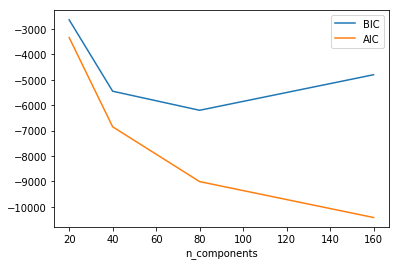

In [56]:
n_components = [20, 40, 80, 160]
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X_bike)
          for n in n_components]

plt.plot(n_components, [m.bic(X_bike) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_bike) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:264: ConvergenceWarning:

Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['Nanum Brush Script OTF'] not found. Falling back to DejaVu Sans



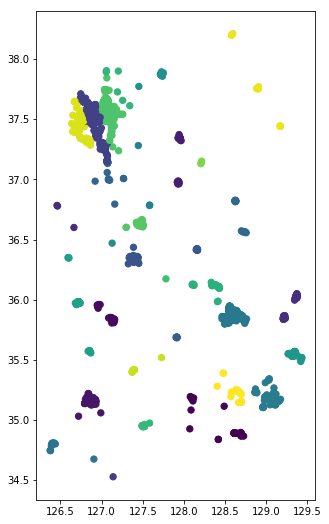

In [57]:
dpgmm = mixture.BayesianGaussianMixture(n_components=80, covariance_type='full').fit(X)
labels = dpgmm.predict(X_bike)

plt.figure(figsize=(5,9))
plt.scatter(X_bike[:, 0], X_bike[:, 1], c=labels, s=40, cmap='viridis');

### 3d plot으로 train dataset 표시해보기

In [144]:
X_3d = pd.DataFrame(train, columns=["경도", "위도", "발생년월일시"])
X_3d

,경도,위도,발생년월일시
0,127.134130,37.435704,2017063023
1,127.131220,35.262534,2017063021
2,126.379922,36.784142,2017063021
3,128.554945,35.875973,2017063019
4,126.906786,37.514993,2017063017
5,126.831392,35.130593,2017063010
6,128.459134,35.674109,2017063009
7,127.098780,37.321961,2017063008
8,126.573561,36.693121,2017063006
9,127.769316,34.985147,2017063004


In [143]:
import plotly.offline as py_off
%matplotlib inline


trace1 = go.Scatter3d(
    x=X_3d.경도,
    y=X_3d.위도,
    z=X_3d.발생년월일시,
    mode='markers',
    marker=dict(
        size=12,
        color=np.random.randn(500),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py_off.iplot(fig, filename='3d-scatter-colorscale')
